# **📚IMPORT LIBRARIES**

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
from PIL import Image #PIL: Python Image Library
import matplotlib.pyplot as plt
import os
import time
import torch.optim as optim

<a id="1"></a>

# **📂LOAD & PREPARE DATA**

In [3]:
def read_images(path,num_img):
    array=np.zeros([num_img,64*32])
    i=0
    for img in os.listdir(path):
        img_path=path + "/" + img
        img=Image.open(img_path,mode="r")
        data=np.asarray(img,dtype="uint8")
        data=data.flatten()
        array[i,:]=data
        i+=1
    return array

In [4]:
train_path="../input/lsi-far-infrared-pedestrian-dataset/LSIFIR/Classification/Train"
test_path="../input/lsi-far-infrared-pedestrian-dataset/LSIFIR/Classification/Test"

train_negative_path=train_path + "/neg"
numOf_train_negative_img=43390
train_positive_path=train_path + "/pos"
numOf_train_positive_img=10208

test_negative_path=test_path + "/neg"
numOf_test_negative_img=22050
test_positive_path=test_path + "/pos"
numOf_test_positive_img=5944

# **➖READ TRAIN NEGATIVE**

In [5]:
# X TRAIN NEGATIVE
train_negative_array=read_images(train_negative_path,numOf_train_negative_img)
x_train_negative_tensor=torch.from_numpy(train_negative_array)
print("Size of X Train Negative Tensor: ", x_train_negative_tensor.size())

# Y TRAIN NEGATIVE
y_train_negative_tensor=torch.zeros(numOf_train_negative_img,dtype=torch.long)
print("Size of Y Train Negative Tensor: ", y_train_negative_tensor.size())

Size of X Train Negative Tensor:  torch.Size([43390, 2048])
Size of Y Train Negative Tensor:  torch.Size([43390])


# **➕READ TRAIN POSITIVE**

In [6]:
# X TRAIN POSITIVE
train_positive_array=read_images(train_positive_path,numOf_train_positive_img)
x_train_positive_tensor=torch.from_numpy(train_positive_array)
print("Size of X Train Positive Tensor: ", x_train_positive_tensor.size())

# Y TRAIN POSITIVE
y_train_positive_tensor=torch.ones(numOf_train_positive_img,dtype=torch.long)
print("Size of Y Train Positive Tensor: ",y_train_positive_tensor.size())

Size of X Train Positive Tensor:  torch.Size([10208, 2048])
Size of Y Train Positive Tensor:  torch.Size([10208])


# **🛠️CONCAT TRAINS**

In [7]:
x_train=torch.cat((x_train_negative_tensor,x_train_positive_tensor),0)
y_train=torch.cat((y_train_negative_tensor,y_train_positive_tensor),0)
print("Size of X Train: ",x_train.size())
print("Size of Y Train: ",y_train.size())

Size of X Train:  torch.Size([53598, 2048])
Size of Y Train:  torch.Size([53598])


# **➖READ TEST NEGATIVE**

In [8]:
# X TEST NEGATIVE
test_negative_array=read_images(test_negative_path,numOf_test_negative_img)
x_test_negative_tensor=torch.from_numpy(test_negative_array[:20855,:])
print("Size of X Test Negative Tensor: ", x_test_negative_tensor.size())

# Y TEST NEGATIVE
y_test_negative_tensor=torch.zeros(20855,dtype=torch.long)
print("Size of Y Test Negative Tensor: ", y_test_negative_tensor.size())

Size of X Test Negative Tensor:  torch.Size([20855, 2048])
Size of Y Test Negative Tensor:  torch.Size([20855])


# **➕READ TEST POSITIVE**

In [9]:
# X TEST POSITIVE
test_positive_array=read_images(test_positive_path,numOf_test_positive_img)
x_test_positive_tensor=torch.from_numpy(test_positive_array)
print("Size of X Train Positive Tensor: ", x_test_positive_tensor.size())

# Y TEST POSITIVE
y_test_positive_tensor=torch.ones(numOf_test_positive_img,dtype=torch.long)
print("Size of Y Train Positive Tensor: ",y_test_positive_tensor.size())

Size of X Train Positive Tensor:  torch.Size([5944, 2048])
Size of Y Train Positive Tensor:  torch.Size([5944])


# **🛠️CONCAT TESTS**

In [10]:
x_test=torch.cat((x_test_negative_tensor,x_test_positive_tensor),0)
y_test=torch.cat((y_test_negative_tensor,y_test_positive_tensor),0)
print("Size of X Test: ",x_test.size())
print("Size of Y Test: ",y_test.size())

Size of X Test:  torch.Size([26799, 2048])
Size of Y Test:  torch.Size([26799])


<a id="2"></a>

# **📊 VISUALIZATION**

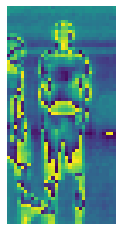

In [11]:
plt.imshow(x_train[43897,:].reshape(64,32))
plt.axis("off");

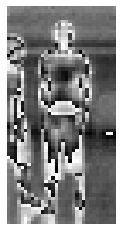

In [12]:
plt.imshow(x_train[43897,:].reshape(64,32),cmap="gray")
plt.axis("off");

<a id="3"></a>

# **🧠 CONVOLUTIONAL MODEL**

In [13]:
# Hyperparameters:
num_epoch=100
num_class=2
batch_size=8933
learning_rate=0.00001

In [14]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel,self).__init__()
        self.cnn1=nn.Conv2d(1,10,5)
        self.pool=nn.MaxPool2d(2,2)
        self.cnn2=nn.Conv2d(10,16,5)
        
        self.fc1=nn.Linear(16*13*5,520)
        self.fc2=nn.Linear(520,130)
        self.fc3=nn.Linear(130,num_class)
        
    def forward(self,x):
        x=self.pool(F.relu((self.cnn1(x))))
        x=self.pool(F.relu((self.cnn2(x))))
        
        x=x.view(-1,16*13*5)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [15]:
# PREPARE DATA:
train=torch.utils.data.TensorDataset(x_train,y_train)
trainLoader=torch.utils.data.DataLoader(train,batch_size=batch_size ,shuffle=True)
test=torch.utils.data.TensorDataset(x_test,y_test)
testLoader=torch.utils.data.DataLoader(test,batch_size=batch_size,shuffle=False)

In [16]:
model=CNNModel()

# **🕹️ LOSS & OPTIMIZER**

In [17]:
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(model.parameters(),lr=learning_rate,momentum=0.8)

# **🕸️ TRAIN NETWORK**

In [18]:
start=time.time()

train_accuracy=[]
test_accuracy=[]
loss_list=[]

use_gpu=False

for epoch in range(num_epoch):
    for i,data in enumerate(trainLoader,0):
        inputs,labels=data
        inputs=inputs.view(batch_size,1,64,32)
        inputs=inputs.float()
        
        # Gradient:
        optimizer.zero_grad()
        # Forward:
        outputs=model(inputs)
        # Loss:
        loss=criterion(outputs,labels)
        # Backward:
        loss.backward()
        # Update Weights:
        optimizer.step()
        
# TEST
    print("Number of EPOCH : ",epoch)
    correct=0
    total=0
    with torch.no_grad():
        for data in testLoader:
            images,labels=data
            images=images.view(batch_size,1,64,32)
            images=images.float()
            
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    testAccuracy=100*correct/total
    print("Accuracy Test: ",testAccuracy)
    test_accuracy.append(testAccuracy)
    
# TRAIN        
    correct=0
    total=0
    with torch.no_grad():
        for data in trainLoader:
            images,labels=data
            images=images.view(batch_size,1,64,32)
            images=images.float()
            
            outputs=model(images)
            _,predicted=torch.max(outputs.data,1)
            total+=labels.size(0)
            correct+=(predicted==labels).sum().item()
    trainAccuracy=100*correct/total
    print("Accuracy Train: ",trainAccuracy)
    train_accuracy.append(trainAccuracy)
print("*********************************")
print("Train is DONE!")
print("*********************************")
end=time.time()
process_time=(end-start)/60
print("Process Time: ",process_time)

Number of EPOCH :  0
Accuracy Test:  77.42453076607336
Accuracy Train:  80.47128624202395
Number of EPOCH :  1
Accuracy Test:  77.61483637449159
Accuracy Train:  80.6839807455502
Number of EPOCH :  2
Accuracy Test:  70.9392141497817
Accuracy Train:  77.2827344303892
Number of EPOCH :  3
Accuracy Test:  68.95033396768537
Accuracy Train:  75.70804880779133
Number of EPOCH :  4
Accuracy Test:  73.93932609425725
Accuracy Train:  80.38732788536886
Number of EPOCH :  5
Accuracy Test:  72.875853576626
Accuracy Train:  80.13545281540355
Number of EPOCH :  6
Accuracy Test:  72.76764058360386
Accuracy Train:  80.27538340982872
Number of EPOCH :  7
Accuracy Test:  73.62215008022687
Accuracy Train:  81.30154110227994
Number of EPOCH :  8
Accuracy Test:  73.83111310123512
Accuracy Train:  81.65416620023136
Number of EPOCH :  9
Accuracy Test:  74.02888167468936
Accuracy Train:  82.04783760588082
Number of EPOCH :  10
Accuracy Test:  74.4057614090078
Accuracy Train:  82.42658308145826
Number of EPOCH

<a id="4"></a>

# **📊 VISUALIZATION of RESULT**

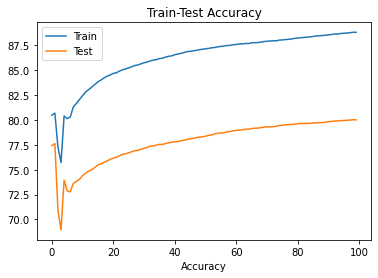

In [19]:
epochs= []
for i in range(num_epoch):
    epochs.append(i)
    
plt.plot(epochs,train_accuracy, label="Train")
plt.plot(epochs,test_accuracy, label="Test")
plt.title("Train-Test Accuracy")
plt.xlabel("Number of Epochs")
plt.xlabel("Accuracy")
plt.legend()
plt.show()